## Setup

In [1]:
%pip install 'vanna[qdrant,openai,mysql]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━

In [28]:
from vanna.openai import OpenAI_Chat
from vanna.qdrant import Qdrant_VectorStore
from qdrant_client import QdrantClient
from openai import OpenAI


In [47]:
class MyVanna(Qdrant_VectorStore, OpenAI_Chat):
    def __init__(self, client=None, config=None):
        # 分别初始化两个父类
        Qdrant_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self,client=client,config=config)

# 配置信息
api_key = "sk-pH3LeinCFI54OlJI238c014eE8D64a0f882cA285375d72A3"
base_url = "https://api.juheai.top/v1"
model_name = "gpt-4o"

# 初始化Qdrant客户端
config = {
	'client': QdrantClient(host="112.124.5.73",port=2280),
  'model': model_name
}

# 创建Vanna实例
vn = MyVanna(
    client=OpenAI(api_key=api_key,base_url=base_url),
    config=config
)


In [48]:
vn.connect_to_mysql(host='dbconn.sealoshzh.site', dbname='order_test', user='root', password='8g529kbq', port=49511)

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [ ]:

# The information schema query may need some tweaking depending on your database. This is a good starting point.
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")

# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

# If you like the plan, then uncomment this and run it to train
# vn.train(plan=plan)



In [14]:

# The following are methods for adding training data. Make sure you modify the examples to match your database.

# DDL statements are powerful because they specify table names, colume names, types, and potentially relationships
# vn.train(ddl="""
#     CREATE TABLE `departments` (
#     `department_id` int NOT NULL AUTO_INCREMENT COMMENT '部门ID，主键',
#     `department_name` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '部门名称',
#     `location` varchar(100) COLLATE utf8mb4_general_ci DEFAULT NULL COMMENT '部门办公地点',
#     `description` text COLLATE utf8mb4_general_ci COMMENT '部门描述',
#     `created_at` timestamp NULL DEFAULT CURRENT_TIMESTAMP COMMENT '创建时间',
#     PRIMARY KEY (`department_id`)
#   ) ENGINE=InnoDB AUTO_INCREMENT=11 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_general_ci COMMENT='公司部门信息表';

# """)

# Sometimes you may want to add documentation about your business terminology or definitions.
# vn.train(documentation="Our business defines OTIF score as the percentage of orders that are delivered on time and in full")

# You can also add SQL queries to your training data. This is useful if you have some queries already laying around. You can just copy and paste those from your editor to begin generating new SQL.
vn.train(question="每个部门有多少员工？",sql="SELECT d.department_name, COUNT(u.user_id) AS employee_count FROM departments d LEFT JOIN users u ON d.department_id = u.department_id GROUP BY d.department_id;")
vn.train(question="最畅销的商品是什么？",sql="SELECT p.product_name, SUM(o.quantity) AS total_sold FROM products p JOIN orders o ON p.product_id = o.product_id GROUP BY p.product_id ORDER BY total_sold DESC LIMIT 1;")
vn.train(question="按类别统计所有商品的库存总量。",sql="SELECT category, SUM(stock_quantity) AS total_stock FROM products GROUP BY category;")
vn.train(question="显示目前上架的所有商品及其价格。",sql="SELECT product_name, price FROM products WHERE is_active = 1;")
vn.train(question="过去一个月内销售额最高的商品是哪一个？",sql="SELECT p.product_name, SUM(p.price * o.quantity) AS total_sales FROM products p JOIN orders o ON p.product_id = o.product_id WHERE o.order_date BETWEEN DATE_SUB(CURDATE(), INTERVAL 1 MONTH) AND CURDATE() GROUP BY p.product_id ORDER BY total_sales DESC LIMIT 1;")
vn.train(question="哪些用户在过去的一年内没有进行任何购买？",sql="SELECT u.username FROM users u LEFT JOIN orders o ON u.user_id = o.user_id AND o.order_date >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR) WHERE o.order_id IS NULL;")



'be7dea21-0343-5f08-b1dd-c81189b62d1d-sql'

In [20]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,061229db-95ec-5783-9e21-968e6e3a0fe5-sql,显示目前上架的所有商品及其价格。,"SELECT product_name, price FROM products WHERE...",sql
1,421d7f13-69c0-530f-882e-f2b4a87e3b3c-sql,按类别统计所有商品的库存总量。,"SELECT category, SUM(stock_quantity) AS total_...",sql
2,518f9914-e59b-54c4-bb75-16936a0bb273-sql,每个部门有多少员工？,"SELECT d.department_name, COUNT(u.user_id) AS ...",sql
3,a7186d83-bd3d-5dc7-9d34-9ec48011002b-sql,最畅销的商品是什么？,"SELECT p.product_name, SUM(o.quantity) AS tota...",sql
4,be7dea21-0343-5f08-b1dd-c81189b62d1d-sql,哪些用户在过去的一年内没有进行任何购买？,SELECT u.username FROM users u LEFT JOIN order...,sql
5,ee05860a-67ff-570b-8fa3-61db9f135f64-sql,过去一个月内销售额最高的商品是哪一个？,"SELECT p.product_name, SUM(p.price * o.quantit...",sql
0,ae4507ed-c64c-5c58-ad6b-fb73046d934b-ddl,None,\n CREATE TABLE `orders` (\n `order_id` ...,ddl
1,b2791109-5431-5c52-9174-410201eb1c10-ddl,None,\n CREATE TABLE `departments` (\n `depar...,ddl
2,b7266249-9c89-5f0a-b584-8ac909c60872-ddl,None,\n CREATE TABLE `products` (\n `product_...,ddl
3,e88faa25-4077-5a91-9f87-9c438ab0b723-ddl,None,\n CREATE TABLE `users` (\n `user_id` in...,ddl


In [ ]:
# You can remove training data if there's obsolete/incorrect information.
vn.remove_training_data(id='1-ddl')


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\n    CREATE TABLE `departments` (\n    `department_id` int NOT NULL AUTO_INCREMENT COMMENT '部门ID，主键',\n    `department_name` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '部门名称',\n    `location` varchar(100) COLLATE utf8mb4_general_ci DEFAULT NULL COMMENT '部门办公地点',\n    `description` text COLLATE utf8mb4_general_ci COMMENT '部门描述',\n    `created_at` timestamp NULL DEFAULT CURRENT_TIMESTAMP COMMENT '创建时间',\n    PRIMARY KEY (`department_id`)\n  ) ENGINE=InnoDB AUTO_INCREMENT=11 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_general_ci COMMENT='公司部门信息表';\n\n\n\n\n\n    CREATE TABLE `users` (\n    `user_id` int NOT NULL AUTO_INCREMENT COMMENT '用户ID，主键',\n    `username` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '用户名',\n   

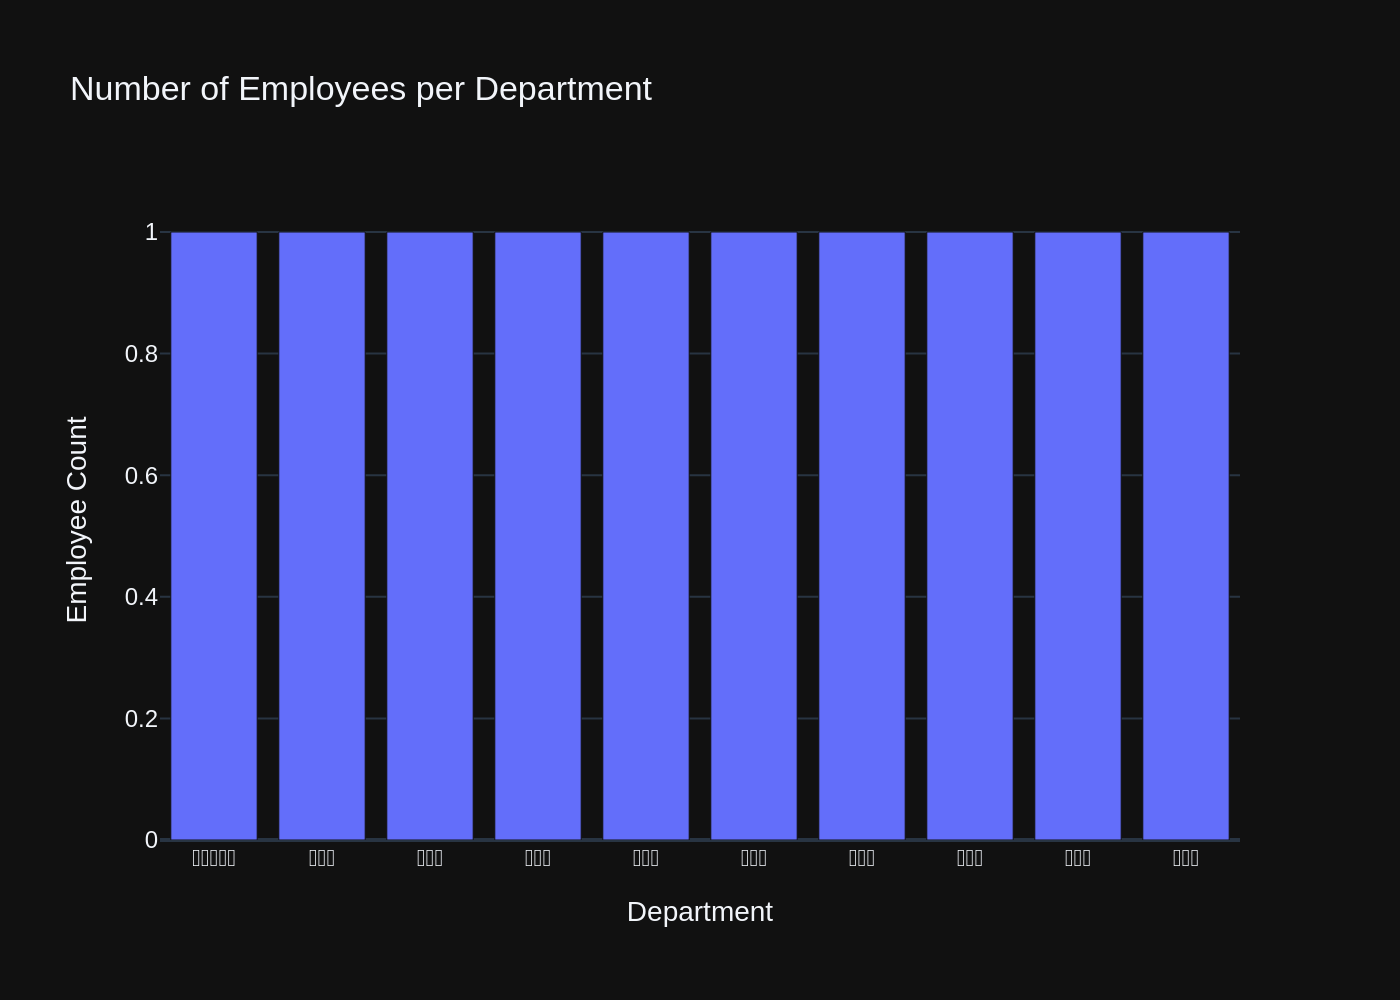

('SELECT d.department_name, COUNT(u.user_id) AS employee_count FROM departments d LEFT JOIN users u ON d.department_id = u.department_id GROUP BY d.department_id;',
   department_name  employee_count
 0           人力资源部               1
 1             技术部               1
 2             市场部               1
 3             财务部               1
 4             销售部               1
 5             研发部               1
 6             客服部               1
 7             物流部               1
 8             采购部               1
 9             行政部               1,
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'department_name=%{x}<br>employee_count=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'offsetgroup': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'ba

In [49]:
vn.ask(question="每个部门有多少员工？")

In [23]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn)
app.run()

Google Colab doesn't support running websocket servers. Disabling debug mode.
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

Your app is running at:
https://8084-m-s-k0qu4g3xatix-b.us-east1-0.prod.colab.dev
 * Serving Flask app 'vanna.flask'
 * Debug mode: off
SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\n    CREATE TABLE `departments` (\n    `department_id` int NOT NULL AUTO_INCREMENT COMMENT '部门ID，主键',\n    `department_name` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '部门名称',\n    `location` varchar(100) COLLATE utf8mb4_general_ci DEFAULT NULL COMMENT '部门办公地点',\n    `description` text COLLATE utf8mb4_general_ci COMMENT '部门描述',\n    `created_at` timestamp NULL DEFAULT CURRENT_TIMESTAMP COMMENT '创建时间',\n    PRIMARY KEY (`department_id`)\n  ) ENGINE=InnoDB AUTO_INCREMENT=11 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_general_ci COMMENT='公司部门信息表';\n\n\n\n\n\n    CREATE TABLE `users` (\n    `use

ERROR:vanna.flask:Exception on /api/v0/generate_sql [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/vanna/flask/__init__.py", line 138, in decorated
    return f(*args

SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\n    CREATE TABLE `users` (\n    `user_id` int NOT NULL AUTO_INCREMENT COMMENT '用户ID，主键',\n    `username` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '用户名',\n    `email` varchar(100) COLLATE utf8mb4_general_ci NOT NULL COMMENT '用户邮箱，唯一',\n    `department_id` int DEFAULT NULL COMMENT '所属部门ID，外键',\n    `hire_date` date DEFAULT NULL COMMENT '入职日期',\n    `salary` decimal(10,2) DEFAULT NULL COMMENT '基本工资',\n    `phone` varchar(20) COLLATE utf8mb4_general_ci DEFAULT NULL COMMENT '联系电话',\n    `status` tinyint DEFAULT '1' COMMENT '状态：1-在职，0-离职',\n    `created_at` timestamp NULL DEFAULT CURRENT_TIMESTAMP COMMENT '创建时间',\n    PRIMARY KEY (`user_id`),\n    UNIQUE KEY `email` (`email`),\n    KEY `idx_department` (`department_id`) COM

ERROR:vanna.flask:Exception on /api/v0/generate_sql [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/vanna/flask/__init__.py", line 138, in decorated
    return f(*args

## Next Steps
Using Vanna via Jupyter notebooks is great for getting started but check out additional customizable interfaces like the
- [Streamlit app](https://github.com/vanna-ai/vanna-streamlit)
- [Flask app](https://github.com/vanna-ai/vanna-flask)
- [Slackbot](https://github.com/vanna-ai/vanna-slack)
